# Prepare some things

## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

import sklearn.metrics
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

2023-06-02 19:45:32.224253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the VaDE model class and some custom functions
import sys
sys.path.append('../')
from models import get_vade_models
from clustering_metrics import evaluate_model
from draw_embeddings import draw_embeddings, draw_matched_labels, compare_reconstructed_images_MNIST

In [3]:
# Disable warnings output (TSNE outputs one very time)
import warnings
warnings.filterwarnings('ignore')

## Load and prepare the MNIST data set

In [4]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

x_train = x_train.reshape(-1, 28*28).astype("float")/255
x_test  = x_test.reshape(-1, 28*28).astype("float")/255

# Pretrain the model

## Construct the AE encoder and decoder modules

## Construct the models and pretrain the autoencoder

In [5]:
IMG_DIM    = 28*28
LATENT_DIM = 10
INTERMEDIATE_DIMS = (512, 512, 2048)
N_CLASSES  = 10

# EPOCHS        = 20 # Recommended number of epochs
EPOCHS        = 5 # Just to test that it works
LEARNING_RATE = 0.001
BATCH_SIZE    = 128

model_pretrain, model_vade = get_vade_models(N_CLASSES, IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)

model_pretrain.compile(optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                       loss      = keras.losses.BinaryCrossentropy(reduction='sum'))

model_pretrain.fit(x          = x_train,
                   epochs     = EPOCHS,
                   batch_size = BATCH_SIZE,
                   verbose    = 1,
                  )

model_pretrain.encoder.save_weights("model_weights/vade/pretrained/encoder")
model_pretrain.decoder.save_weights("model_weights/vade/pretrained/decoder")

# model_pretrain.encoder.load_weights("model_weights/vade/pretrained/encoder")
# model_pretrain.decoder.load_weights("model_weights/vade/pretrained/decoder")

2023-06-02 19:45:36.342210: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/5
469/469 [==============================] - 44s 91ms/step - loss: 22.9371
Epoch 2/5
469/469 [==============================] - 43s 91ms/step - loss: 15.5682
Epoch 3/5
469/469 [==============================] - 42s 89ms/step - loss: 14.3437
Epoch 4/5
469/469 [==============================] - 41s 87ms/step - loss: 13.7513
Epoch 5/5
469/469 [==============================] - 41s 87ms/step - loss: 13.3814


## Show the resulting embeddings

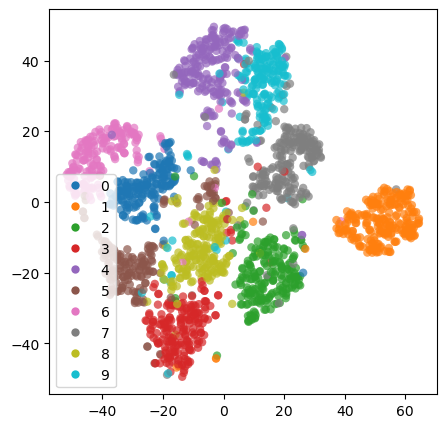

In [6]:
z = model_pretrain.encode(x_test[0:2000])

tsne   = TSNE(n_components=2, init='pca')
z_tsne = tsne.fit_transform(z)

draw_embeddings(z_tsne, y_test[0:2000])

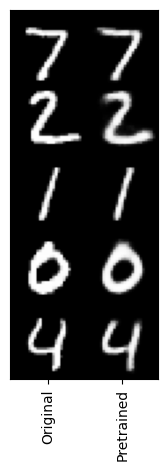

In [7]:
compare_orig_vs_pretrained = compare_reconstructed_images_MNIST(x_test, model_pretrain.encoder, model_pretrain.decoder, ("Original", "Pretrained"))

# Fine-tune the model

## Construct the full VaDE model

Load the pretrained weights for the encoder and decoder modules:

In [8]:
# model_pretrain.encoder.load_weights("model_weights/vade/pretrained/encoder")
# model_pretrain.decoder.load_weights("model_weights/vade/pretrained/decoder")

## Initialize the parameters

Initialize the model parameters from a GMM model:

In [9]:
z_train = model_vade.encode_only_mu(x_train)

gmm = GaussianMixture(n_components=N_CLASSES, covariance_type='diag', n_init=10)
gmm.fit(z_train)

for weight in model_vade.trainable_weights:
    if weight.name == "pi:0":
        weight.assign(K.log(K.constant(gmm.weights_)))
    elif weight.name == "mu:0":
        weight.assign(K.constant(gmm.means_))
    elif weight.name == "logvar:0":
        weight.assign(K.log(K.constant(gmm.covariances_)))

model_vade.save_weights("model_weights/vade/pretrained/vade")
# model_vade.load_weights("model_weights/vade/pretrained/vade")

Evaluate the clustering performance before fine-tunning the model:

{'Acc': 0.7243,
 'ARI': 0.589924409415257,
 'AMI': 0.6763817049175672,
 'Sil': 0.15174404}

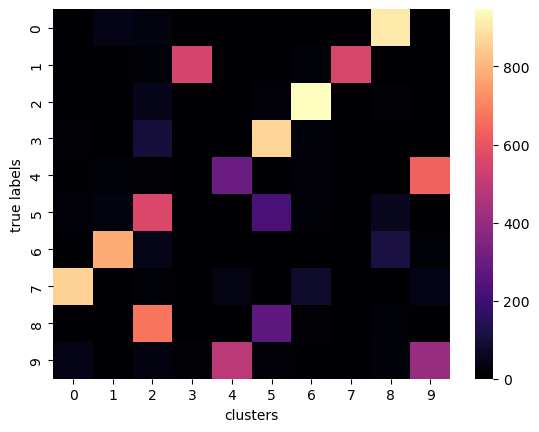

In [10]:
evaluate_model(x_test, y_test, model_vade.classify, model_vade.encode_only_mu)

## Train the model

Prepare some custom callbacks: every 10 epochs, we will decrease de learning rate and print the clustering accuracy on the test dataset.

In [11]:
def scheduler(epoch, lr):
    if (epoch+1) % SCHEDULE == 0:
        lr = lr * 0.9
    return lr

def print_accuracy(epoch, logs):
    if (epoch+1) % SCHEDULE == 0:
        c_test = model_vade.classify(x_test)
        confusion_matrix = sklearn.metrics.confusion_matrix(y_test, c_test)
        c_test = confusion_matrix.argmax(0)[c_test]
        print(f"Current accuracy on test dataset: {sklearn.metrics.accuracy_score(y_test, c_test):.4f}")

callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.LambdaCallback(on_epoch_end=print_accuracy)]

Train the model:

In [12]:
# EPOCHS        = 200 # Recommended number of epochs
EPOCHS        = 5 # Just to test that it works
LEARNING_RATE = 0.002
BATCH_SIZE    = 128
SCHEDULE      = 10

model_vade.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

model_vade.fit(x          = x_train,
               epochs     = EPOCHS,
               batch_size = BATCH_SIZE,
               callbacks  = callback,
               verbose    = 1,
              )

model_vade.save_weights("model_weights/vade/finetuned/vade")
# model_vade.load_weights("model_weights/vade/finetuned/vade")

Epoch 1/5
469/469 [==============================] - 46s 94ms/step - loss: 112.5034 - lr: 0.0020
Epoch 2/5
469/469 [==============================] - 43s 93ms/step - loss: 108.0182 - lr: 0.0020
Epoch 3/5
469/469 [==============================] - 44s 95ms/step - loss: 106.6908 - lr: 0.0020
Epoch 4/5
469/469 [==============================] - 43s 92ms/step - loss: 105.8864 - lr: 0.0020
Epoch 5/5
469/469 [==============================] - 45s 95ms/step - loss: 104.8886 - lr: 0.0020


## Show the resulting embeddings

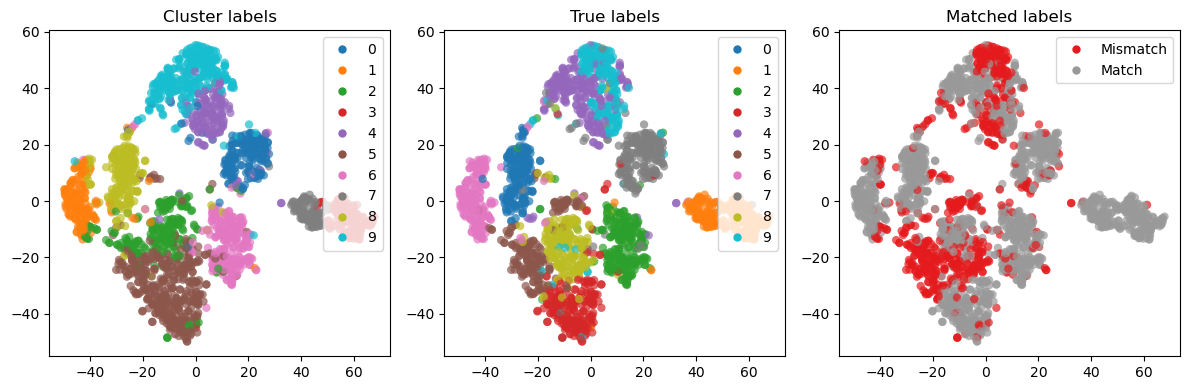

In [13]:
z = model_vade.encode_only_mu(x_test[0:2000])

tsne   = TSNE(n_components=2, init='pca')
z_tsne = tsne.fit_transform(z)
c_test = model_vade.classify(x_test)

draw_matched_labels(z_tsne, y_test[0:2000], c_test[0:2000])

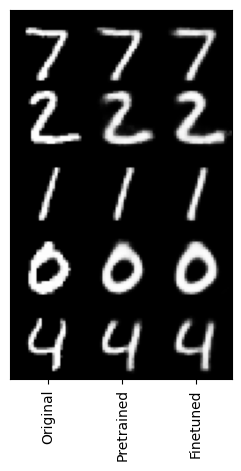

In [14]:
_ = compare_reconstructed_images_MNIST(x_test, model_vade.encoder, model_vade.decoder, ("Original", "Pretrained", "Finetuned"), old_figure=compare_orig_vs_pretrained)

## Evaluate the model

{'Acc': 0.716,
 'ARI': 0.6010114911918546,
 'AMI': 0.7012405983227465,
 'Sil': 0.18933138}

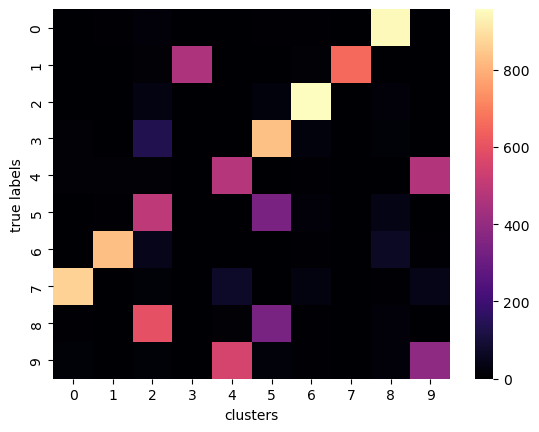

In [15]:
evaluate_model(x_test, y_test, model_vade.classify, model_vade.encode_only_mu)